# k-means

## アルゴリズム

$D$次元ユークリッド空間上の確率変数$X$の$N$個の観測点で構成されるデータ集合$\{x_1, ..., x_N\}$があるとする。

このデータを$K$個のクラスターに分割したい。（簡単のため、まず$K$は既知とする。）

クラスターとは、クラスター内のデータ点同士の距離がクラスター外の点との距離よりも小さいグループであると想定する。

プロトタイプと呼ばれる$K$個の$D$次元ベクトル$\boldsymbol{\mu}_k (k = 1,\dots, K)$を導入し、これが$k$番目のクラスターの中心を表すとする。

目的関数$L$は  **歪み尺度 (distortion measure)** と呼ばれる、各データ点と$\boldsymbol{\mu}_k$の二乗距離の総和で、

$$
L = \sum^N_{i=1} \sum^K_{k=1} r_{ik} \| \boldsymbol{x}_i - \boldsymbol{\mu}_k \|^2
$$

となる。ここで$r_{ik}\in \{0, 1\}$は、$i$番目の観測点ベクトル$\boldsymbol{x}_i$が$k$に属するかどうかを示す変数。

k-meansの推定は$r_{ik}$の推定と$\boldsymbol{\mu}_k$の推定を交互に繰り返すことで求める（EMアルゴリズムのように行う）。

### $r_{ik}$の推定

$k$に属するのは$\boldsymbol{x}_i$と$\boldsymbol{\mu}_j (j=1,\dots, K)$の距離が他のクラスより短いときなので、

$$
r_{ik} =
\begin{cases}
1 & k = \arg \min_j \| \boldsymbol{x}_i - \boldsymbol{\mu}_j \|^2\\
0 & それ以外
\end{cases}
$$

となる。

### $\boldsymbol{\mu}_k$の推定

$r_{ik}$を固定した下での$\boldsymbol{\mu}_k$の最適化を考える。目的関数$L$は$\boldsymbol{\mu}_k$の二次関数であり、$\boldsymbol{\mu}_k$に関する偏微分を0とおくことで最適化できる。

$$
2 \sum^N_{i=1} r_{ik} (\boldsymbol{x}_i - \boldsymbol{\mu}_k) = 0
$$

これを$\boldsymbol{\mu}_k$について解くと、


$$
\boldsymbol{\mu}_k = \frac{\sum^N_{i=1} r_{ik} \boldsymbol{x}_i}{\sum^N_{i=1} r_{ik}}
$$

分母は$k$番目のクラスタに選ばれたサンプル数に等しいので、上の式は単純に算術平均の形になっている。

この「$r_{ik}$の推定」と「$\boldsymbol{\mu}_k$の推定」の2ステップを、データ点のクラスターへの再割り当てがおこらなくなるまで、あるいはあらかじめ決めておいた反復数に達するまで繰り返してクラスタリングを行う。

## 実装

### データセットの用意

irisデータを使う

In [79]:
# データセットの用意
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 0:2]  # 2列だけ特徴を選択
y = iris.target

# 簡単のため標準化する
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# for plot
df = pd.DataFrame(X, columns=iris.feature_names[0:2])
class_indexes = range(len(iris.target_names))
df["y"] = pd.Series(y).map(dict(zip(class_indexes, iris.target_names)))

df.head()

,sepal length (cm),sepal width (cm),y
0,-0.900681,1.019004,setosa
1,-1.143017,-0.131979,setosa
2,-1.385353,0.328414,setosa
3,-1.506521,0.098217,setosa
4,-1.021849,1.249201,setosa


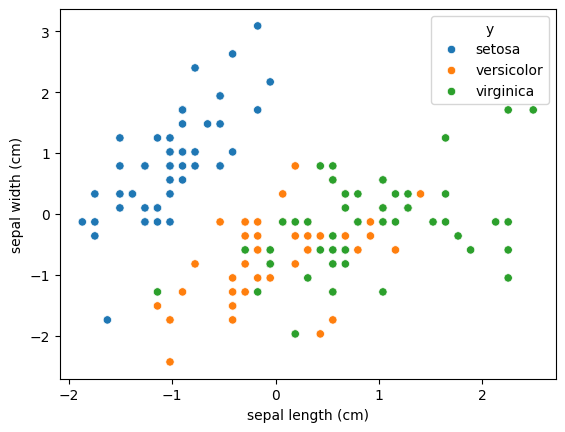

In [83]:
import seaborn as sns
sns.scatterplot(df, x="sepal length (cm)", y="sepal width (cm)", hue="y")
plt.show()

#### 1. $r$の推定

乱数で適当な$\mu$の初期値を作る

In [94]:
D = X.shape[1]
K = 3

# 乱数でμ初期化
np.random.seed(0)
mu = np.random.rand(D, K)
mu

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411]])

$$
r_{ik} =
\begin{cases}
1 & k = \arg \min_j \| \boldsymbol{x}_i - \boldsymbol{\mu}_j \|^2\\
0 & それ以外
\end{cases}
$$

なので

In [95]:
N = len(y)

def estimate_r(mu):
    r = np.zeros(shape=(N, K))
    for i in range(N):
        dists = []
        for j in range(K):
            dist = np.linalg.norm(X[i] - mu[:, j], ord=2)
            dists.append(dist)
        min_j = np.argmin(dists)
        # k == argmin(二乗距離) かどうかでr[i,k]を決定
        for k in range(K):
            r[i, k] = 1 * (k == min_j)
    return r

#### 2. $\mu$の推定

$$
\boldsymbol{\mu}_k = \frac{\sum^N_{i=1} r_{ik} \boldsymbol{x}_i}{\sum^N_{i=1} r_{ik}}
$$

なので、そのクラスに属するサンプルで平均をとる

In [96]:
def estimate_mu(r, mu):
    for k in range(K):
        n_samples = np.sum(r[:, k])
        if n_samples == 0: # 当該クラスのサンプル数が0になったらどうするんだろう
            mu[:, k] = np.zeros_like(mu[:, k])
            continue

        mu[:, k] = (r[:, k] @ X) / n_samples
    return mu

In [97]:
n_iter = 3
for i in range(n_iter):
    r = estimate_r(mu)
    mu = estimate_mu(r, mu)
    print(f"""
--- iteration {i} ---
{r[:5, ]=}
{mu=}
""")


--- iteration 0 ---
r[:5, ]=array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])
mu=array([[-0.86241763,  0.65672986, -0.00538524],
       [ 0.16687246, -0.54940295,  1.76074949]])


--- iteration 1 ---
r[:5, ]=array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])
mu=array([[-1.03447069,  0.60948424, -0.01615572],
       [ 0.17494954, -0.51096196,  1.67506514]])


--- iteration 2 ---
r[:5, ]=array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])
mu=array([[-1.09454976,  0.58326887, -0.01615572],
       [ 0.19541148, -0.49758611,  1.67506514]])



## 分類としての評価

In [117]:
# 割り当てられたクラスターのラベル
clusters = np.argmax(r, axis=1)
clusters

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [107]:
# 真のラベル
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

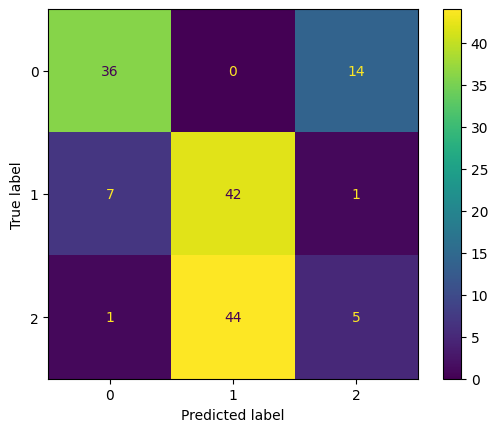

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

分類精度でみるといまいちだが、もともとデータ点にオーバーラップが多いため特徴選びが問題

### Centroidの位置

人間の感覚とも概ね合致したクラスターの中心点が取れているのではないか

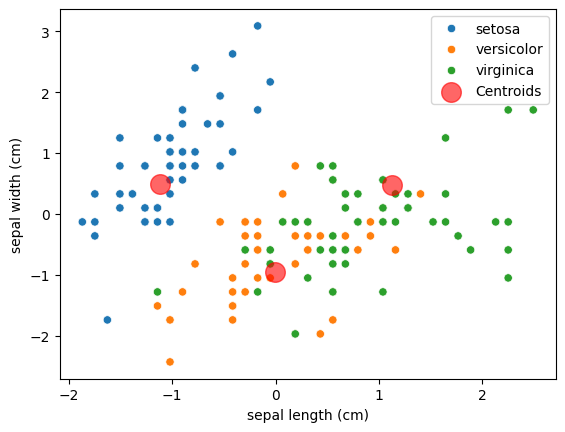

In [125]:
sns.scatterplot(df, x="sepal length (cm)", y="sepal width (cm)", hue="y")

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
centers_pca = pca.fit_transform(mu.T)

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.6, label='Centroids')
plt.legend()
plt.show()

## 参考

- PRML 下
- [2.3. Clustering — scikit-learn 1.5.1 documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means)
